In [2]:
import mask
import numpy as np
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from field_importer import get_field
import xarray as xr
import matplotlib.animation as animation
from IPython import display
from scipy.ndimage import gaussian_filter1d as gf

%config Completer.use_jedi = False

In [3]:
def mask_large_vals(array,threshold=10):
    
    array = np.ma.masked_where(np.abs(array) > threshold, array)
    
    array = np.ma.filled(array.astype(float), np.nan)
    
    return array

# Read in ice motion vectors

In [4]:
mdata = Dataset('/home/robbie/Dropbox/beaufort_sea/icemotion_weekly_nh_25km_20200101_20210204_ql.nc')
lons = np.array(mdata['longitude'])
lats = np.array(mdata['latitude'])

mdata

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    version: QuickLook data based on Ice Motion version 4.1
    release_date: February 2021
    Conventions: CF-1.4
    citation: Tschudi, M. A., Meier, W. N., and Stewart, J. S.: An enhancement to sea ice motion and age products, The Cryosphere Discuss., https://doi.org/10.5194/tc-2019-40, in review, 2019.
    dataset_doi: 10.5067/O0XI8PPYEZJ6
    dimensions(sizes): x(361), y(361), time(57)
    variables(dimensions): float64 x(x), float64 y(y), float64 time(time), int32 crs(), float32 u(time,y,x), float32 v(time,y,x), int16 number_of_observations(time,y,x), float32 latitude(y,x), float32 longitude(y,x)
    groups: 

# Read ice age data

In [6]:
adata = Dataset('/home/robbie/Dropbox/beaufort_sea/iceage_nh_12.5km_20200101_20210204_ql.nc')
alons = np.array(adata['longitude'])
alats = np.array(adata['latitude'])

# Read the dates from the ice age data

In [25]:
e0 = datetime.date(1970,1,1)
t = np.array(adata['time'])

dates = [e0 + datetime.timedelta(days=d) for d in t]
print('Available Dates:')
print(dates)

def get_index_of_date(dates,date_obj):
    
    ind = dates.index(date_obj)
    
    return(ind)

# Example get the index of last day in August

# I've had to use the 2nd Sept because I only have the weekly product

d = datetime.date(year=2020,month=9,day=2)

ind = get_index_of_date(dates,d)

print()
print('Index of second Sept:')
print(ind)
    

Available Dates:
[datetime.date(2020, 1, 1), datetime.date(2020, 1, 8), datetime.date(2020, 1, 15), datetime.date(2020, 1, 22), datetime.date(2020, 1, 29), datetime.date(2020, 2, 5), datetime.date(2020, 2, 12), datetime.date(2020, 2, 19), datetime.date(2020, 2, 26), datetime.date(2020, 3, 4), datetime.date(2020, 3, 11), datetime.date(2020, 3, 18), datetime.date(2020, 3, 25), datetime.date(2020, 4, 1), datetime.date(2020, 4, 8), datetime.date(2020, 4, 15), datetime.date(2020, 4, 22), datetime.date(2020, 4, 29), datetime.date(2020, 5, 6), datetime.date(2020, 5, 13), datetime.date(2020, 5, 20), datetime.date(2020, 5, 27), datetime.date(2020, 6, 3), datetime.date(2020, 6, 10), datetime.date(2020, 6, 17), datetime.date(2020, 6, 24), datetime.date(2020, 7, 1), datetime.date(2020, 7, 8), datetime.date(2020, 7, 15), datetime.date(2020, 7, 22), datetime.date(2020, 7, 29), datetime.date(2020, 8, 5), datetime.date(2020, 8, 12), datetime.date(2020, 8, 19), datetime.date(2020, 8, 26), datetime.date

# Make an example plot of ice age of 2/9/2020 using the index we just found

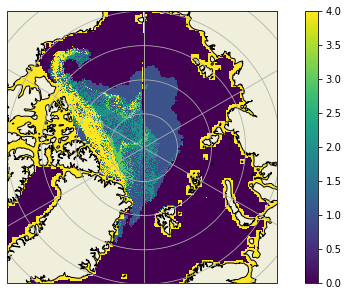

In [21]:
def plot(lon,
          lat,
          data,
          bounding_lat=65,
          land=True,
          gridlines=True,
          figsize=[10,5],
          color_scale=(None,None),
          color_scheme='plasma',
          scale=100):
    
    """
    Plots a north polar plot using cartopy. \
    Must be supplied with gridded arrays of lon, lat and data
    """

    
    # Make figure template

    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.NorthPolarStereo())

    
    if land == True: # Superimposes a land mask
        ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

    # Set the extent of the plot, using the latitudinal limit given in the function arguments    
    
    ax.set_extent([-180, 180, 90, 70], ccrs.PlateCarree())
    
    if gridlines == True:
        ax.gridlines()
        
    vmin, vmax = color_scale[0], color_scale[1]
    
    c = ax.pcolormesh(lon, lat, data[:,:],
                      transform=ccrs.PlateCarree(),
                      vmin=vmin, vmax=vmax,
             )
    plt.colorbar(c)
    
    plt.show()
    

    
plot(alons, alats, adata['age_of_sea_ice'][35], color_scale=(0,4))

# Read the time data from the ice motion files, and make a list of dates from it

In [30]:
e0 = datetime.date(1970,1,1)
t = np.array(mdata['time'])

dates = [e0 + datetime.timedelta(days=d) for d in t]

dates[-1]

datetime.date(2021, 1, 29)

In [17]:
d_u = np.array(mdata['u']) ; d_v = np.array(mdata['v'])

d_u.shape

(57, 361, 361)

In [18]:
t_u = d_u.copy()

d_u = gf(d_u, 2, axis=0)
d_v = gf(d_v, 2, axis=0)

start_day = datetime.date(year=2020, month=1, day=1)
start_day_of_year = start_day.timetuple().tm_yday

0
0
10
20
30
40
50


IndexError: list index out of range

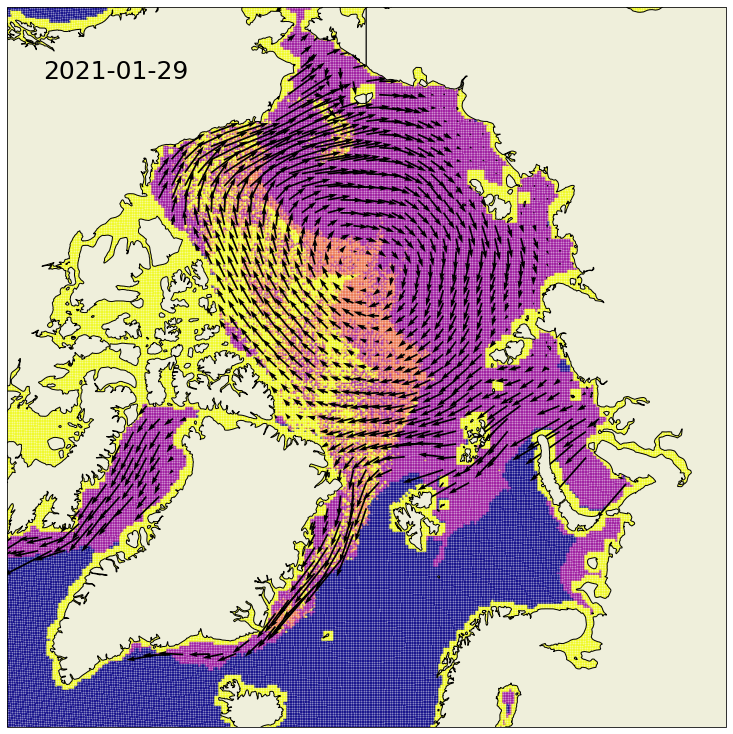

In [27]:
hemisphere = 'n'

fig = plt.figure(figsize=(10,10))

if hemisphere == 'n':
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())    
else:  
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.set_extent([-180, 180, -90, -55], ccrs.PlateCarree())

ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

ax.margins()

s = 4
scale = 200
size_lim = 20

bg = ax.pcolormesh(alons, 
                   alats, 
                   adata['age_of_sea_ice'][0,:-1,:-1], 
                    vmin = 0, 
                    vmax = 3,
                    transform=ccrs.PlateCarree(),
                    cmap='plasma',
                    alpha=0.5)


qv =   ax.quiver(lons[::s,::s],
                 lats[::s,::s],
                 d_u[0][::s,::s],
                 d_v[0][::s,::s],
                 transform=ccrs.PlateCarree(),
                 scale=scale,
                )

    
ann = ax.annotate('',
                  xy=(0.05,0.9),
                  xycoords='axes fraction',
                  fontsize=25,
                  ha='left')

ann.set_animated(True)
    
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)

########################################################

def animate(frame):
    
    if frame % 10 == 0: #Track progress
        print(frame)

    day = frame
    
    date = start_day + datetime.timedelta(days=day*7)
    
    ann.set_text(f'{dates[frame]}')

    u = d_u[start_day_of_year+day-1][::s,::s]
    v = d_v[start_day_of_year+day-1][::s,::s]
    
    u = mask_large_vals(u,threshold=size_lim)
    v = mask_large_vals(v,threshold=size_lim)
    
    u = np.ma.masked_where(np.isnan(u), u)
    v = np.ma.masked_where(np.isnan(v), v)
    
    qv.set_UVC(u,v)
    
    bg.set_array(adata['age_of_sea_ice'][start_day_of_year+day-1,:-1,:-1].ravel())


#######################################################

ani = animation.FuncAnimation(fig,
                              animate,
                             frames= range(0,58),
                             )    

video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()

In [26]:
Writer = animation.writers['ffmpeg']

writer = Writer(fps=3, metadata=dict(artist='Robbie Mallett CPOM UCL'))

ani.save('/home/robbie/Dropbox/beaufort_sea/IMV_quiver_with_types.mp4', writer=writer)

0
0
10
20
30
40
50


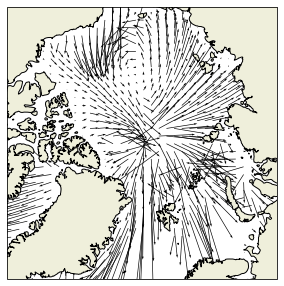

In [160]:
def qplot(lon,
          lat,
          data_u,
          data_v,
          bounding_lat=65,
          land=True,
          gridlines=True,
          figsize=[10,5],
          color_scale=(None,None),
          color_scheme='plasma',
          scale=100):
    
    """
    Plots a north polar plot using cartopy. \
    Must be supplied with gridded arrays of lon, lat and data
    """

    
    # Make figure template

    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.NorthPolarStereo())

    
    if land == True: # Superimposes a land mask
        ax.add_feature(cartopy.feature.LAND, edgecolor='black',zorder=1)

    # Set the extent of the plot, using the latitudinal limit given in the function arguments    
    
    ax.set_extent([-180, 180, 90, 70], ccrs.PlateCarree())
    
#     if gridlines == True:
#         ax.gridlines()
        
#     vmin, vmax = color_scale[0], color_scale[1]
    
    ax.quiver(lon, lat, data_u, data_v,
              transform=ccrs.PlateCarree(),
              scale=scale,
             )
    
    plt.show()
    
year = 2011 

d = Dataset(f'/home/robbie/Dropbox/Data/IMV/icemotion_daily_nh_25km_{year}0101_{year}1231_v4.1.nc')

sow_u = np.nanmean(d['u'][95:100],axis=0)
sow_v = np.nanmean(d['v'][95:100],axis=0)


IMV_field_u = mask_large_vals(sow_u,threshold=1000)
IMV_field_v = mask_large_vals(sow_v,threshold=1000)

# IMV_field_u = sam_mask(IMV_field_u,min_lat=80,max_lat=82)
# IMV_field_v = sam_mask(IMV_field_v,min_lat=80,max_lat=82)

IMV_field_N = -IMV_field_u * np.sin(np.radians(lon_grid)) + IMV_field_v * np.cos(np.radians(lon_grid))

# IMV_field_u.shape

skipper = 5

qplot(lon_grid[::skipper,::skipper],lat_grid[::skipper,::skipper],
      IMV_field_u[::skipper,::skipper],IMV_field_v[::skipper,::skipper],scale=50)

